#### 👕 클로젯셰어 과제 가이드라인 
- 분석 자료 : 최근 3개월간 신규 구매 데이터 일부

- 분석 필요 내용


**1. 구매 소요 시간 분석**


    1-1. 가입일로부터 구매일까지 전환된 소요시간 분석
        - 최근 3개월 전체 분석 / 각 월 별 분석
        - 분기 경향 / 월 별 변동사항 확인 -> 트렌드 분석
            ex. 가입 1일 이내 전환 유저 : 10% -> 15% 상승 성과

**2. 구매 상품 트렌드 분석**
 
     2-1. 유저당 주문 수량 분석
         - 최근 3개월 전체 분석 / 각 월 별 분석
         - 분기 경향 / 월 별 변동사항 확인 -> 트렌드 분석
     2-2. 주문 아이템 분석
         - 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
         - 신규 유저들의 구매 트렌드 파악

**3. 분석 내용 토대로 인사이트 도출**

    3-1. 분석 내용 도식화
        - 1~2의 분석 내용 종합 및 도식화 (표 또는 그래프)
        - 유사성을 갖는 결과에 대하여 그룹화
    3-2. 인사이트 도출
        - 해당 결과를 통해 나타나는 사항 정리
        - 인사이트 도출 혹은 새로운 제안사항 전달 (없을 시 진행하지 않아도 무방)

- 
용어 및 칼럼 설명
  
     brandnm : 아이템 브랜드명
     
     goodsnm : 아이템 명
     
     USER : 개별 유저 식별 값
     
     reg_date : 개별 유저 가입일
     
     order_date : 아이템 주문일
     
     p_type : 주문 상품 종류 [7days (7일권) / 4days (4일권)]
     
     sub_type : 주문 상품 카테고리 [BA – 가방 / O – 아우터 / D – 드레스 / T – 상의 / B – 하의 / TB – 투피스]
     
     app_yn : 어플리케이션 사용 여부 [Y – 어플리케이션 사용 / (공백) – 어플리케이션 미사용]
    

#### 모듈 import

In [189]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style(style="white")
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.unicode_minus'] = False    # minus

from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

# interactive
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 노트북 세팅
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

# 연관분석
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#### Data import

##### 과제 data

In [716]:
# 과제 data
closet = pd.read_excel('../week3/클로젯셰어_과제DB 대체 자료.xlsx',)
df = closet.copy()
# col > lower
df.columns=list(map(lambda x: x.lower(),df.columns))

In [717]:
df = df.sort_values(['order_date','user']).reset_index(drop=True)

In [408]:
df.head(2)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y


##### 외부 data

In [409]:
# 크롤링 data 가격정보
price = pd.read_excel('../week3/tag_price_df.xlsx')
# remove space
price.columns=list(map(lambda x: x.replace(' ',''),price.columns))
price=price.iloc[:,1:]
price.head(2)

,brandnm,goodsnm,tag,4d_price,7d_price
0,Gucci,flower dionysus shoulder bag beige,#위켄드,49000.00,59000.00
1,Gucci,dionysus cross bag,#위켄드,49000.00,59000.00


In [706]:
# 클로젯셰어 네이버 트렌드 정보
navertrend = pd.read_excel('../week3/navertrend.xlsx')
navertrend.head()

,date,index
0,2021-01-01,33.18
1,2021-01-02,38.07
2,2021-01-03,46.10
3,2021-01-04,52.04
4,2021-01-05,59.14


### 데이터 개요

#### 과제 data

In [344]:
df.head(5)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN,2020,08,2020-08,5.00,1,53,4,1
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y,2020,04,2020-04,4.00,1,53,4,0
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4.00,1,53,4,0
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4.00,1,53,4,0
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,NaN,2020,12,2020-12,3.00,1,53,5,0


In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brandnm          1442 non-null   object 
 1   goodsnm          1471 non-null   object 
 2   user             1471 non-null   object 
 3   reg_date         1466 non-null   object 
 4   order_date       1471 non-null   object 
 5   p_type           1471 non-null   object 
 6   sub_type         1471 non-null   object 
 7   app_yn           1295 non-null   object 
 8   reg_year         1466 non-null   object 
 9   reg_month        1466 non-null   object 
 10  reg_yearmonth    1466 non-null   object 
 11  reg_dayofweek    1466 non-null   float64
 12  order_month      1471 non-null   int64  
 13  order_week       1471 non-null   int64  
 14  order_dayofweek  1471 non-null   int64  
 15  brandnm_luxury   1471 non-null   int32  
dtypes: float64(1), int32(1), int64(3), object(11)
memory usage: 

In [346]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
reg_dayofweek,1466.00,2.71,1.98,0.00,1.00,2.00,4.00,6.00
order_month,1471.00,2.18,0.81,1.00,1.00,2.00,3.00,3.00
order_week,1471.00,7.88,5.28,1.00,5.00,8.00,11.00,53.00
order_dayofweek,1471.00,2.39,1.68,0.00,1.00,2.00,3.00,6.00
brandnm_luxury,1471.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00


#### 외부 data
1. `price` 상품별 가격 정보 - 크롤링
2. `navertrend` 클로젯셰어 검색 트렌드 정보 - https://datalab.naver.com/keyword/trendResult.naver?hashKey=N_d01ade15c99d850887f521c7b4b3da99

##### price

In [355]:
price.head() 

,brandnm,goodsnm,tag,4d_price,7d_price
0,Gucci,flower dionysus shoulder bag beige,#위켄드,49000.00,59000.00
1,Gucci,dionysus cross bag,#위켄드,49000.00,59000.00
2,Tory Burch,flower ethnic pattern cross bag white,#위켄드,34000.00,44000.00
3,Chloe,faye small bag black,#오피스 #위켄드,34000.00,44000.00
4,Prada,logo hobo bag black,#일상,39000.00,49000.00


In [356]:
print(price['4d_price'].unique())
print(price['7d_price'].unique())

[49000. 34000. 39000. 59000.    nan 29000. 15000. 24000. 38000. 19000.
 12000.]
[59000. 44000. 49000. 69000.    nan 39000. 25000. 34000. 58000. 29000.
 22000.]


In [357]:
price.describe().T

,count,mean,std,min,25%,50%,75%,max
4d_price,540.00,39983.33,10221.74,12000.00,34000.00,39000.00,49000.00,59000.00
7d_price,540.00,50001.85,10227.20,22000.00,44000.00,49000.00,59000.00,69000.00


##### navertrend

In [691]:
navertrend.describe().T

,count,mean,std,min,25%,50%,75%,max
index,90.00,44.27,12.70,22.82,35.51,41.56,51.28,100.00


In [707]:
navertrend['date']=pd.to_datetime(navertrend['date'])
navertrend['month']=navertrend['date'].dt.strftime('%m')
navertrend['dayofweek']=navertrend['date'].dt.dayofweek
navertrend['week']=navertrend['date'].dt.week

In [708]:
navertrend.head(3)

,date,index,month,dayofweek,week
0,2021-01-01,33.18,01,4,53
1,2021-01-02,38.07,01,5,53
2,2021-01-03,46.10,01,6,53


#### 데이터 개요 정리

In [718]:
# 상품 카테고리 한글로
def rename_cate(row):
    if pd.isnull(row):
        return np.nan
    else:
        return row.replace('BA', '가방').replace('O', '아우터').replace('D', '드레스').replace('TP','투피스').replace('T', '상의').\
    replace('B', '하의')    
    
df['sub_type'] = df['sub_type'].apply(rename_cate)

In [719]:
print('브랜드 수:', df.brandnm.nunique(),'\n')
print('상품 수:', df.goodsnm.nunique(),'\n')
print('유저 수:', df.user.nunique(),'\n')
print('구매 타입 수:', df.p_type.nunique())
print('구매 타입 수:', df.p_type.unique(),'\n')
print('서브 타입 수:', df.sub_type.nunique())
print('서브 타입 수:', df.sub_type.unique(),'\n')
print('가입 정보 기간:', pd.to_datetime(df['reg_date']).min() ,"~", pd.to_datetime(df['reg_date']).max())
print('구매 정보 기간:', df.order_date.min() ,"~", df.order_date.max())

브랜드 수: 245 

상품 수: 979 

유저 수: 1234 

구매 타입 수: 2
구매 타입 수: ['7days' '4days'] 

서브 타입 수: 6
서브 타입 수: ['아우터' '드레스' '가방' '상의' '하의' '투피스'] 

가입 정보 기간: 2017-06-24 00:00:00 ~ 2021-03-31 00:00:00
구매 정보 기간: 2021-01-01 00:00:00 ~ 2021-03-31 00:00:00


In [720]:
df.groupby('user')['order_date'].count().sort_values().to_frame().reset_index().value_counts('order_date').to_frame().reset_index().rename(columns={0:'유저 수',                                                                                                                              'order_date':'주문 건 수'})

,주문 건 수,유저 수
0,1,1095
1,2,89
2,3,33
3,4,8
4,6,3
5,7,2
6,5,1
7,9,1
8,10,1
9,11,1


In [681]:
df.brandnm.value_counts().head(10).to_frame()

,brandnm
Gucci,232
Chanel,90
Saint Laurent,86
Louis Vuitton,79
Prada,58
Burberry,53
Yves Saint Laurent,38
Thom Browne,33
N/A,29
Fendi,29


### 결측치 확인/처리


In [410]:
df.isnull().sum()

brandnm       29 
goodsnm       0  
user          0  
reg_date      5  
order_date    0  
p_type        0  
sub_type      0  
app_yn        176
dtype: int64

#### brandnm        

##### 직접 서치    

In [721]:
df.loc[146, 'brandnm'] = 'Fendi' # 상의는 YCH ?
df.loc[147, 'brandnm'] = 'Mojosphine'
df.loc[160, 'brandnm'] = 'Fayewoo'
df.loc[220, 'brandnm'] = 'Nakes'
df.loc[267, 'brandnm'] = 'Vw vera Wang'
df.loc[282, 'brandnm'] = 'Gucci'
df.loc[285, 'brandnm'] = 'Chanel'
df.loc[329, 'brandnm'] = 'Plastic Island'
df.loc[342, 'brandnm'] = 'Sonia Rykiel'
df.loc[368, 'brandnm'] = 'El estilo de Claire'
df.loc[373, 'brandnm'] = 'Moschino'
df.loc[443, 'brandnm'] = 'Saint James'
df.loc[505, 'brandnm'] = 'EunjoKoh'
df.loc[525, 'brandnm'] = 'Vw vera Wang'
df.loc[526, 'brandnm'] = 'Rejina Pyo'
df.loc[544, 'brandnm'] = 'Miu Miu'
df.loc[765, 'brandnm'] = 'El estilo de Claire'
df.loc[766, 'brandnm'] = 'Miu Miu'
df.loc[879, 'brandnm'] = 'Olive des Olive'
df.loc[892, 'brandnm'] = 'Sandro'
df.loc[931, 'brandnm'] = 'Balmain' # + 다른 브랜드
df.loc[946, 'brandnm'] = 'Fayewoo'
df.loc[957, 'brandnm'] = 'It michaa'
df.loc[1062, 'brandnm'] = 'SJYP' # 현재 상의는 있는데 하의는 없음. 이제 상의만 렌트하는듯. 상의 브랜드 넣음
df.loc[1210, 'brandnm'] = 'Mine' # Mine, Chee U 두 브랜드에서 똑같은 이름의 투피스 상품이 있음. 인지도에 따라 Mine으로 넣음
df.loc[1385, 'brandnm'] = 'Mojosphine'
df.loc[1405, 'brandnm'] = 'Plastic Island'

##### fillna('N/A')       

In [722]:
df['brandnm'] = df['brandnm'].fillna('N/A')

#### app_yn : fillna(0)  

In [723]:
# app_yn 값 0, 1 치환
df['app_yn'] = df['app_yn'].fillna(0)
df.loc[(df.app_yn == 'Y'), 'app_yn'] = 1

#### reg_date : fillna(method='pad')

In [724]:
# reg_date 순서대로 user의 id가 부여되었는지 확인
reg_user = df[df['reg_date'].notnull()].sort_values('user').sort_values('reg_date').reset_index().iloc[:,3:5]
print(reg_user)

for i in np.arange(0,len(reg_user)-1):
    if int(reg_user.user[i][1:]) > int(reg_user.user[i+1][1:]):
        
        if reg_user.reg_date[i] != reg_user.reg_date[i+1]:
            print("순서대로 부여되지 않았습니다.")

print("")
print("user의 id는 reg_date의 순서대로 부여되었다.")

          user   reg_date
0     a11612   2017-06-24
1     a11803   2017-07-02
2     a13637   2018-03-09
3     a13741   2018-03-20
4     a13934   2018-03-27
...      ...          ...
1461  a1151479 2021-03-31
1462  a1151481 2021-03-31
1463  a1151496 2021-03-31
1464  a1151499 2021-03-31
1465  a1151564 2021-03-31

[1466 rows x 2 columns]

user의 id는 reg_date의 순서대로 부여되었다.


In [725]:
# reg date null 처리를 위해
df = df.sort_values(['user','reg_date'])
df['reg_date']=df['reg_date'].fillna(method = 'pad')

In [726]:
# order_date, user 기준 재정렬 
df = df.sort_values(['order_date','user']).reset_index(drop=True)

In [727]:
#df.query('(user == "a1144008")|(user == "a1142855")|(user == "a1146490")|(user == "a1145478")|(user == "a1149094")')
df.isnull().sum()

brandnm       0
goodsnm       0
user          0
reg_date      0
order_date    0
p_type        0
sub_type      0
app_yn        0
dtype: int64

### 컬럼 추가, 테이블 생성

#### 날짜 컬럼 추가

In [728]:
# 가입 정보 관련 날짜 변수 추가 
df['reg_date']=pd.to_datetime(df['reg_date'])
df['reg_year']=df['reg_date'].dt.strftime('%Y')
df['reg_month']=df['reg_date'].dt.strftime('%m')
df['reg_yearmonth']=df['reg_date'].dt.strftime('%Y-%m')
df['reg_dayofweek']=df['reg_date'].dt.dayofweek
df['order_month']=df['order_date'].dt.month
df['order_week']=df['order_date'].dt.week
df['order_dayofweek']=df['order_date'].dt.dayofweek
# date continuous변환
df['order_date']=pd.to_datetime(df['order_date']).dt.date
df['reg_date']=pd.to_datetime(df['reg_date']).dt.date

#### 럭셔리 브랜드 컬럼 추가 brannm_luxury

In [729]:
# 2021 top 10 list
luxury_list=['GUCCI','Louis Vuitton','Cartier','Chanel','Hermes','Ferrari','Rolex','Dior','Christian Dior','COACH','Estee Lauder','Tiffany & Co.',
'Guerlain','Burberry','Prada','Lancôme','Omega','Clarins','Bulgari','Moncler','Saint Laurent','SK-II','McLaren','TAG Heuer','Givenchy','Lamborghini','Armani','Bottega Veneta','Rolls- Royce',
'Bentley','Aston Martin','Loewe','Maserati','Van Cleef & Arpels','Valentino','Salvatore Ferragamo','Shiseido','Sulwhasoo','Tissot','Versace','Bobbi Brown','Montblanc','Tom Ford','Longines','Cle de Peau Beaute','Jaeger-LeCoultre',
'Celine','Dolce & Gabbana','Miu Miu','Fendi']
# brandnm luxury 
luxury_list_lower = []

for item in luxury_list:
  item = item.lower()
  luxury_list_lower.append(item)

# brandnm luxury 
df['brandnm_luxury']=np.where(df['brandnm'].str.lower().isin(luxury_list_lower), 1,0)
df.head()

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,아우터,0,2020,08,2020-08,5,1,53,4,1
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,아우터,1,2020,04,2020-04,4,1,53,4,0
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,드레스,1,2020,04,2020-04,4,1,53,4,0
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,드레스,1,2020,04,2020-04,4,1,53,4,0
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,아우터,0,2020,12,2020-12,3,1,53,5,0


#### User Segmentation 컬럼 추가 
1. seg_new 가입시기 기준 : 신규 유저 (2021 가입) vs 기존 유저
2. seg_heavy 구매건수 기준 : 헤비 유저 (1회 주문시 2건이상 주문) vs 논헤비 유저
3. seg_lag 구매전환소요시간 기준 : 가입일reg_date 구매일자 order_date간 차이를 구매전환소요시간 lag라 정의하고, lag기준으로 seg_lag('Sameday', '~2Weeks', '~1month', '~1year', '1year+') 유저 그룹

##### seg_new 가입시기 기준 
신규 유저 (2021 가입) vs 기존 유저

In [730]:
# 신규 유저 구분자 1, 0
new_list = df.query('(reg_yearmonth=="2021-01") |(reg_yearmonth=="2021-02")|(reg_yearmonth=="2021-03")').user.tolist()
df['seg_new'] = np.where(df.user.isin(new_list), 1, 0)

##### seg_heavy 구매건수 기준 
헤비 유저 (1회 주문시 2건이상 주문) vs 논헤비 유저

In [903]:
# 4건 이상 heavy user로 규정
heavy_list=df_user.query('order_count>3').user.tolist()
df['seg_heavy']=np.where(df.user.isin(heavy_list),1,0)

##### seg_lag 구매전환소요시간 기준 
1. 가입일reg_date 구매일자 order_date간 차이를 구매전환소요시간 lag라 정의 
2. lag기준으로 특징, 분포 파악
3. seg_lag('Sameday', '~2weeks', '~3months', '3months+') 유저 그룹 생성

count   1471.00
mean    106.52 
std     206.63 
min     0.00   
25%     1.00   
50%     4.00   
75%     88.00  
max     1304.00
Name: lag, dtype: float64


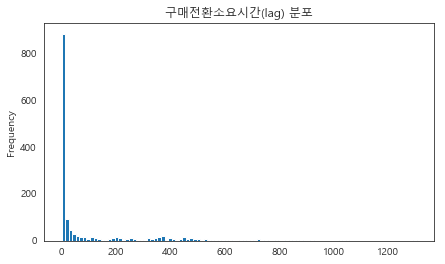

In [929]:
# 구매전환 소요시간 
# lag : 구매일 - 가입일 간 소요일수 계산
df['lag'] = (pd.to_datetime(df['order_date']) - pd.to_datetime(df['reg_date'])).dt.days

# lag_month : lag를 30일로 나누어 소요월 계산
df['lag_month'] = df['lag']/30
df['order_month'] = pd.to_datetime(df['order_date']).dt.month

# lag 분포 
df['lag'].plot(kind='hist',bins = 100, figsize=(7,4), title='구매전환소요시간(lag) 분포')
print(df.describe().lag.T)

In [934]:
# 가입일로부터 첫주문일까지 걸린 시간 lag_lvl에 5개 분류로 표기
# Sameday : 가입당일 주문 / ~2Week : 가입 2주일 내 주문 / ~1month :가입 3주차 ~ 1개월 내 주문 / ~1year : 가입 1개월차 ~ 1년 내 주문 / 1year+ : 가입한지 1년 지나서 주문
cut_labels = ['Sameday', '~2weeks', '~3months', '3months+']
cut_bins = [-1, 1, 14, 90, 1304]
df['seg_lag'] = pd.cut(df['lag'], bins=cut_bins, labels=cut_labels)

##### seg_luxury 럭셔리 구매 비율

In [912]:
df.groupby('user').sum()['order_count']

,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury,seg_new,seg_heavy,lag,lag_month
user,,,,,,,,,
a1100548,10,6,26,4,0,0,0,638,21.27
a1100887,1,3,13,0,1,0,0,314,10.47
a1101514,0,2,5,4,0,0,0,256,8.53
a1101645,1,2,8,1,1,0,0,273,9.10
a1102068,4,3,9,3,1,0,0,279,9.30
...,...,...,...,...,...,...,...,...,...
a198621,5,1,3,3,0,0,0,271,9.03
a19897,5,2,7,1,0,0,0,857,28.57
a199351,6,1,1,2,1,0,0,248,8.27


#### 유저별 구매 정보 테이블 생성 df_user

In [935]:
# df_user 유저 기본 정보 테이블생성
df_user = df.groupby(['user','reg_date','reg_yearmonth','order_date','order_month','order_week','order_dayofweek'])['goodsnm'].count().to_frame().reset_index().rename(columns={'goodsnm':'order_count'}) 
ptype = df.pivot_table(index='user', columns='p_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
subtype = df.pivot_table(index='user', columns='sub_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
app = df.pivot_table(index='user', columns='app_yn',values= 'order_date',aggfunc='count').fillna(0).reset_index().rename(columns={'Y':'app'}) 

# merge
df_user = df_user.merge(ptype, how='left', on='user').merge(app, how='left', on='user').merge(luxury, how='left', on='user').merge(subtype, how='left', on='user').fillna(0)

# user segmentation (3.4) 정보 추가
# seg_new
df_user['seg_new'] = np.where(df_user.user.isin(new_list), 1, 0)
# seg_heavy
df_user['seg_heavy']=np.where(df_user.user.isin(heavy_list),1,0)
# lag, seg_lag
df_user = df_user.merge(df.groupby('user')['lag'].min().reset_index().sort_values(by = 'lag', ascending = False).reset_index(drop=True), 
              on='user', how='left')
df_user['seg_lag'] = pd.cut(df_user['lag'], bins=cut_bins, labels=cut_labels)
# seg_luxury
df_user['seg_luxury'] = df_user['brandnm_luxury']/df_user['order_count']

df_user.head(5)

,user,reg_date,reg_yearmonth,order_date,order_month,order_week,order_dayofweek,order_count,4days,7days,...,드레스,상의,아우터,투피스,하의,seg_new,seg_heavy,lag,seg_lag,seg_luxury
0,a1100548,2020-05-16,2020-05,2021-03-31,3,13,2,2,2.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0,0,319,3months+,0.00
1,a1100887,2020-05-19,2020-05,2021-03-29,3,13,0,1,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0,0,314,3months+,0.00
2,a1101514,2020-05-25,2020-05,2021-02-05,2,5,4,1,1.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0,0,256,3months+,0.00
3,a1101645,2020-05-26,2020-05,2021-02-23,2,8,1,1,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0,0,273,3months+,0.00
4,a1102068,2020-05-29,2020-05,2021-03-04,3,9,3,1,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0,0,279,3months+,0.00


In [738]:
# shape check
print(df.shape)
print(df_user.shape)
print(df.user.nunique())

(1471, 21)
(1234, 23)
1234


### EDA 
📃 **분석 수행시 설정한 기준 및 정의**
> **기존 컬럼 관련**
1. order_date는 유저의 `최초구매일자`로 고려하여 구매전환소요시간`lag`를 계산함
2. 본 데이터셋으로는 상품의 판매 시작 시기를 구분할 수 없으므로, 구매 상품 기반으로 트렌드를 파악함

📃 **세부 분석 내용**


#### User segmentation 기반 분석 

**목적**

개별 고객을 이해하고 segmentation 기준으로 마케팅 및 서비스 방안 모색

**User Segmentation 기준**
1. seg_lag (주문시점-가입시점) : 가입일reg_date 구매일자 order_date간 차이 
2. seg_new (가입시점 2021) : 신규유저(1) vs 기존유저(0)
3. seg_heavy (주문건수 4건 이상) : 헤비유저(1) vs 라이트유저(0)
4. seg_luxury (전체 구매 품목 수 중 럭셔리제품 비율 )

##### seg_new 신규유저 vs 기존 유저

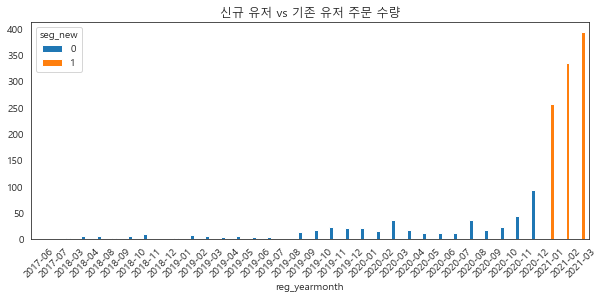

In [762]:
df_user.pivot_table(index='reg_yearmonth',columns='seg_new',
                   values='order_count', aggfunc='sum').plot.bar(rot=45, figsize=(10,4),
                                                                title ='신규 유저 vs 기존 유저 주문 수량')

In [959]:
# 브랜드별 신규유저 주문건수 & 구유저 주문건수(unique 값)
df_brandnm_신규유저_주문건수 = df.query("seg_new == 1").groupby(['brandnm'])['user'].count().reset_index().\
                                rename(columns={'user':'신규유저주문건수'}).sort_values(by='신규유저주문건수', ascending=False)
df_brandnm_구유저_주문건수 = df.query("seg_new == 0").groupby(['brandnm'])['user'].count().reset_index().\
                            rename(columns={'user':'구유저주문건수'}).sort_values(by='구유저주문건수', ascending=False)
# df_brandnm_신규유저_주문건수 & df_brandnm_구유저_주문건수 병합
df_brandnm_주문건수 = df_brandnm_구유저_주문건수.head(15).merge(df_brandnm_신규유저_주문건수.head(15), how='outer', on='brandnm')
df_brandnm_주문건수.rename(columns={'구유저주문건수':'구유저 주문건수', '신규유저주문건수':'신규유저 주문건수'}, inplace=True)
df_brandnm_주문건수.fillna(0, inplace=True)
'''
구유저 주문건수가 0인 경우에는 증감률이 inf로 나옴(증감률 계산할 땐 기준년도로 나누게 되는데 0으로는 나눌 수 없으므로)
임의적으로 구유저 주문자수 0인 경우(Celine, Miu Miu, It michaa)는 1로 바꾸고 증감률 계산
'''
df_brandnm_주문건수.loc[df_brandnm_주문건수['brandnm'].isin(['Celine', 'It michaa', 'Miu Miu']), '구유저 주문건수'] = 1
df_brandnm_주문건수['주문건수 증감률'] = (df_brandnm_주문건수['신규유저 주문건수'] - df_brandnm_주문건수['구유저 주문건수']) / (df_brandnm_주문건수['구유저 주문건수']) * 100
df_brandnm_주문건수.sort_values(by='주문건수 증감률', ascending=False)

,brandnm,구유저 주문건수,신규유저 주문건수,주문건수 증감률
17,El estilo de Claire,0.00,13.00,inf
15,Celine,1.00,21.00,2000.00
16,It michaa,1.00,13.00,1200.00
5,Louis Vuitton,18.00,60.00,233.33
3,Saint Laurent,20.00,65.00,225.00
0,Gucci,63.00,168.00,166.67
1,Chanel,25.00,63.00,152.00
11,Fendi,9.00,21.00,133.33
12,Christian Dior,8.00,14.00,75.00
4,Burberry,19.00,33.00,73.68


(편집 필요)
- 신규유저는 Vivienne Westwood, Lucky Chouette, El estilo de Claire를 1건도 구매하지 않음
(구유저도 해당 브랜드에 대해선 7건 구매. 이 두 브랜드는 구유저나 신규유저에게 인기 없는 브랜드일 것으로 추측)
- 주문수량 증감률 1위 브랜드는 Celine(구유저는 0건 구매, 신규유저는 22건 구매)
- 주문수량 증감률 2위 브랜드는 It michaa, Miu Miu(구유저는 0건 구매, 신규유저는 12건 구매)
→ 증감률 1위, 2위 브랜드에 대하여 신규유저의 주문수량 자체가 많은 것은 아니지만 증감률만 보면 상위권.
그러나, 지난 회의 때 찬서님이 말씀하신 것처럼 만약 Celine와 It michaa, Miu Miu 브랜드가 클로젯셰어에 처음 등록된 시점이 2021년이라면?
→ Celine와 It michaa, Miu Miu에 대한 수요 증가가 구매 트렌드의 변화라고 보기에는 어려울 수 있음. 따라서, 이 세 개 브랜드는 트렌드 판단에서는 논외로 치는 것이 합리적일 것이라 생각함
- 구유저 대비 신규유저의 주문건수 증감률이 높은 순으로는 Celine, It michaa, Miu Miu, Louis Vuitton, Saint Laurent, Fendi, Gucci, Chanel순
- 구유저 주문건수 0인 3개 브랜드 제외하면, Louis Vuitton, Saint Laurent, Fendi, Gucci, Chanel 순으로 증감률 높음


In [ ]:
(재환님 크로스탭 추가 필요)

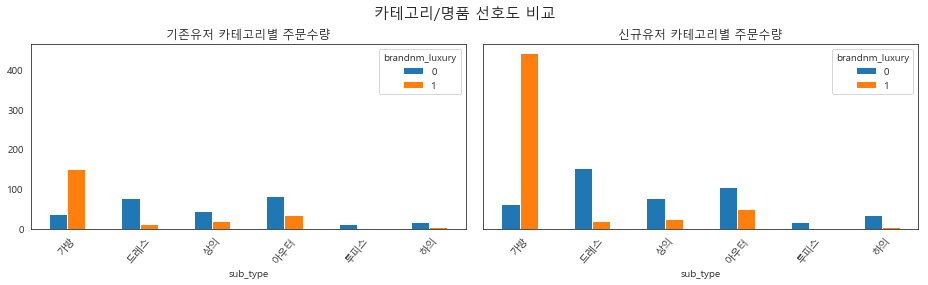

In [827]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,4), sharey=True)
fig.suptitle('카테고리/명품 선호도 비교', fontsize=15)
df.query('seg_new==0').pivot_table(index='sub_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=50, title= '기존유저 카테고리별 주문수량', ax=axes[0])
df.query('seg_new==1').pivot_table(index='sub_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=50, title='신규유저 카테고리별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

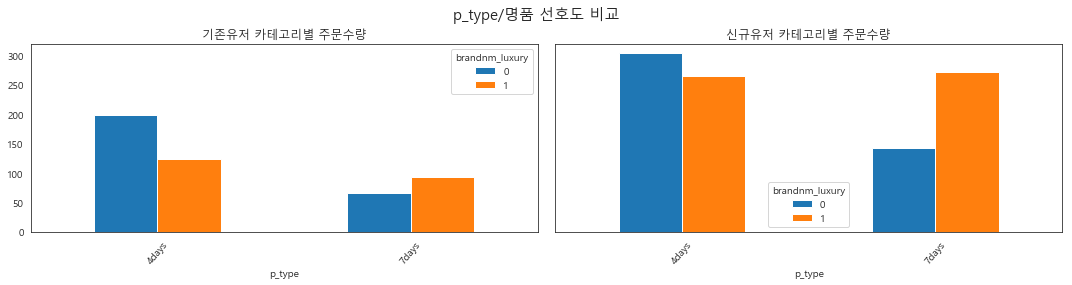

In [863]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,4), sharey=True)
fig.suptitle('p_type/명품 선호도 비교', fontsize=15)
df.query('seg_new==0').pivot_table(index='p_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=50, title='기존유저 카테고리별 주문수량', ax=axes[0])

df.query('seg_new==1').pivot_table(index='p_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=50, title='신규유저 카테고리별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

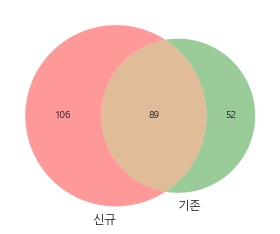

In [871]:
# 신규 유저 vs 기존 유저 주문 브랜드 차이 
plt.figure(figsize=(5,4))
venn2([set(df.query('seg_new==1')['brandnm'].tolist()),set(df.query('seg_new==0')['brandnm'].tolist())],
     set_labels = ('신규','기존'))
plt.show()

54.0 %
Salvatore Ferragamo    9
Mine                   8
Olive des Olive        4
Debb                   4
Ralph Lauren           3
Johnny Hates Jazz      3
MSGM                   3
Banana Republic        3
Alexander Wang         3
Studio Tomboy          3
Name: brandnm, dtype: int64


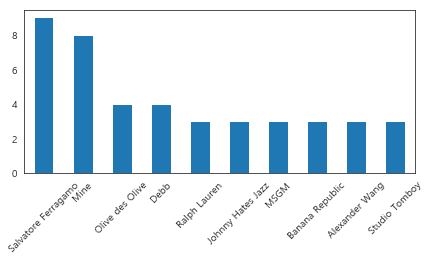

In [875]:
new_brand_list = list(set(df.query('seg_new==1')['brandnm'].tolist())-set(df.query('seg_new==0')['brandnm'].tolist()))
print(round(len(new_brand_list)/195*100,0),"%")
print(df[df.brandnm.isin(new_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10))
df[df.brandnm.isin(new_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, figsize=(7,3))

📍 insights

**카테고리/명품 선호도**
1. 신규유저 명품 & 가방 집중 뚜렷
2. 기존유저/신규유저 모두 가방 외 카테고리에서는 명품 X (카테고리 특성)

**p_type/명품 선호도**
1. 신규유저 그룹이 주문 상품의 명품 여부에 따라 4vs7일권 선호 차이 뚜렷 : 명품인 경우 7일권 더 선호

**브랜드 선호도**
1. 신규 유저 vs 기존 유저 브랜드 선호도 비교시 차이 존재
2. 1의 차이 중, 신규 유저만 구매한 브랜드 106개(54%) 브랜드 파악
    - 상대적으로 덜 고가의 브랜드 존재


##### seg_lag sameday 유저 ~ 3months+유저

Text(0.5, 1.0, '구매수량(x)과 구매전환소요시간(y)')

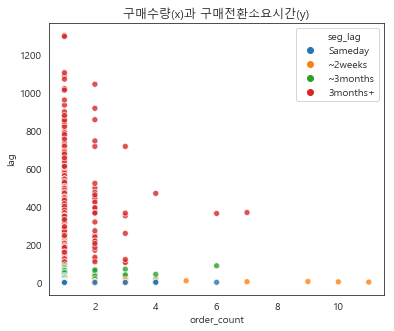

In [947]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_user, y='lag', x='order_count', 
                hue='seg_lag', alpha =0.8)
plt.title('구매수량(x)과 구매전환소요시간(y)')

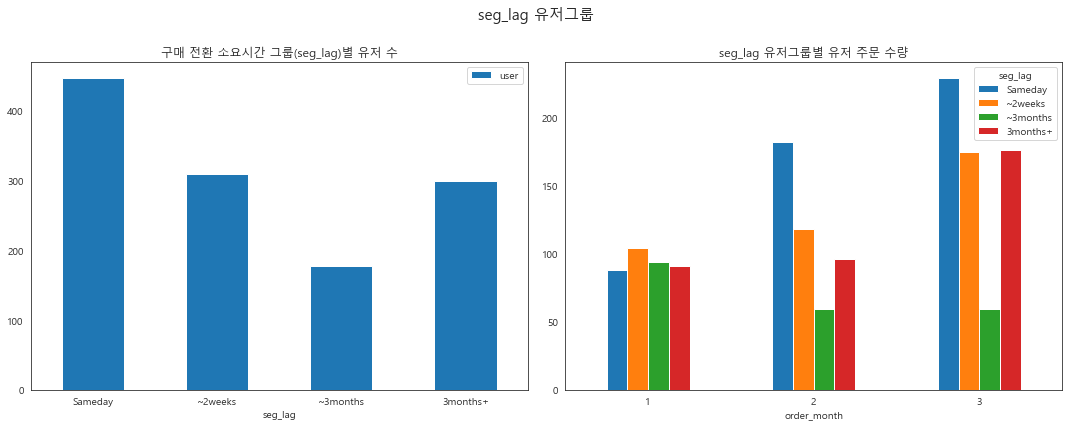

In [950]:
fig, axes = plt.subplots( ncols=2,figsize=(15,6))
fig.suptitle('seg_lag 유저그룹', fontsize=15)

df_user.pivot_table(index='seg_lag', values='user',
                    aggfunc='count').reset_index().plot(kind='bar', x='seg_lag',
                                                       rot=0,  ax=axes[0],
                                                   title='구매 전환 소요시간 그룹(seg_lag)별 유저 수')

df_user.pivot_table(index='order_month',columns='seg_lag',
                   values='order_count', aggfunc='sum').plot.bar(ax=axes[1],
                                                                 rot=0, 
                                                                title ='seg_lag 유저그룹별 유저 주문 수량')

fig.tight_layout()
fig.subplots_adjust(top=0.85)

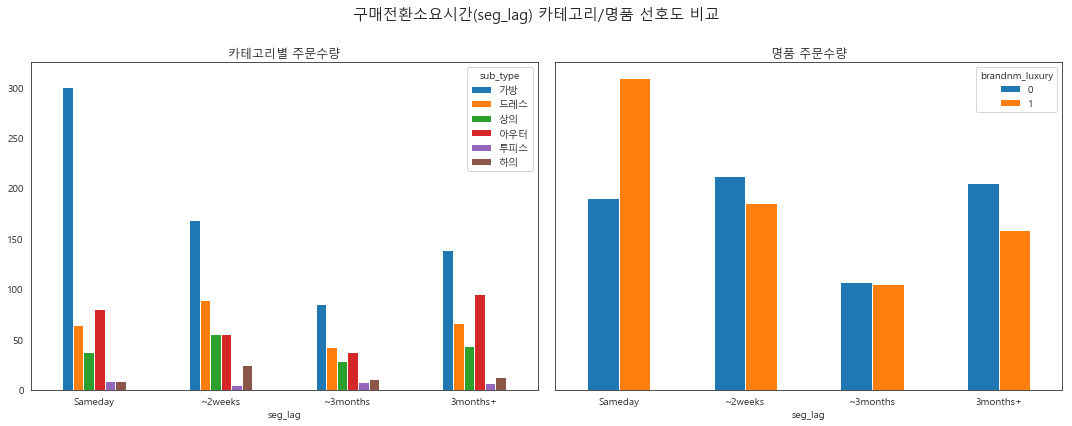

In [951]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6), sharey=True)
fig.suptitle('구매전환소요시간(seg_lag) 카테고리/명품 선호도 비교', fontsize=15)
df.pivot_table(index='seg_lag', columns='sub_type',
               values='order_date', aggfunc='count').plot.bar(rot=0, title= '카테고리별 주문수량', ax=axes[0])
df.pivot_table(index='seg_lag', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=0, title='명품 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

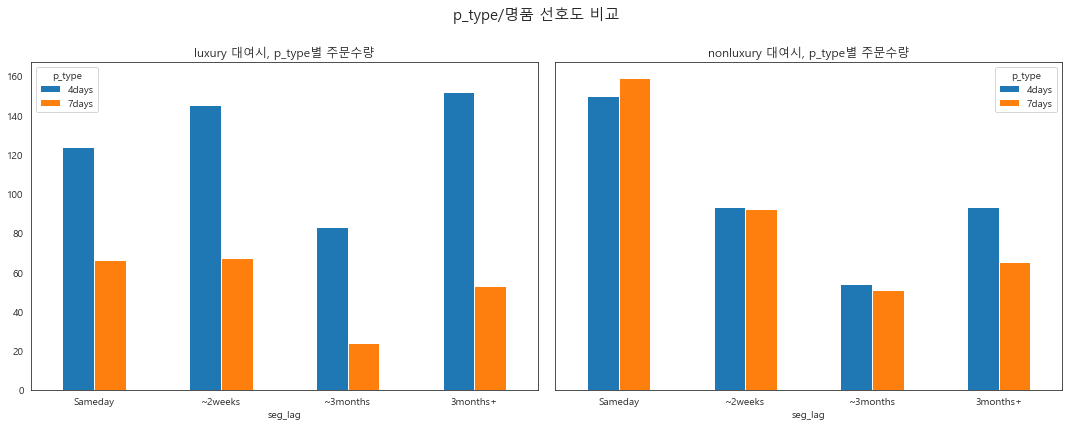

In [943]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6), sharey=True)
fig.suptitle('p_type/명품 선호도 비교', fontsize=15)
df.query('brandnm_luxury==0').pivot_table(index='seg_lag', columns='p_type',
               values='order_date', aggfunc='count').plot.bar(rot=0, 
                                                              title='luxury 대여시, p_type별 주문수량', ax=axes[0])

df.query('brandnm_luxury==1').pivot_table(index='seg_lag', columns='p_type',
               values='order_date', aggfunc='count').plot.bar(rot=0,
                                                              title='nonluxury 대여시, p_type별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

 📍 Insights
 
- `~1year&1year+` 유저 대부분 1-2 건, 유저 주문 건수 많은 경우 `~2weeks` 그룹
- `~3month` 상대적으로 가입 2주 이후-1달 구매 유저 적음 >  가입일 2주이내 구매로 전환 유도하는 전략으로 가입 후 2주안에 구매시 적용되는 쿠폰 제공하면 극대화되지 않을까? 
 
**카테고리/명품 선호도**
1. lag 긴 그룹일수록 의류(드레스/아우터)의 비중 증가 
2. `Sameday` 그룹 명품 선호 뚜렷 (=신규유저의 명품&가방 집중현상)
3. `1year+`그룹 명품 아닌 브랜드 주문 많음 
    - 2,3 으로 볼때 `1year+`그룹(dormant/inactive user) 구매 유도 전략 수립시, 타겟팅 제품이 달라야함

**p_type/명품 선호도**
1. non luxury 대여시, 4vs7일권 차이 크지 않음 
    - 명품 대여 기간 길수록 가격이 높아져서?
    - 4일권 구매건수 늘리는 전략으로? 
    
        ex 가입 후 2주내 명품가방 대여시 다음 대여시 사용할 수 있는 4일권 할인 쿠폰
        
        



##### seg_heavy

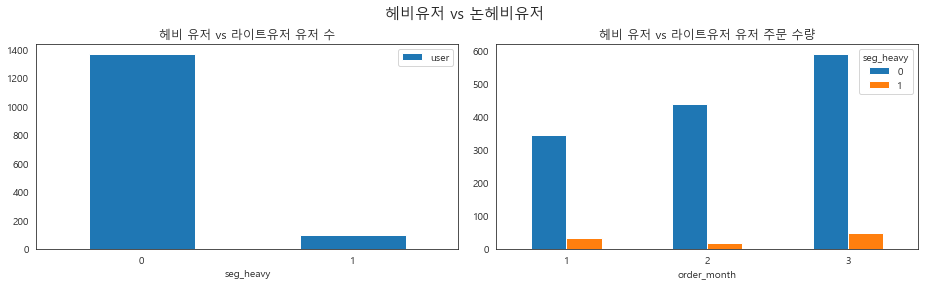

In [968]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
fig.suptitle('헤비유저 vs 논헤비유저', fontsize=15)

df.pivot_table(index='seg_heavy',
                   values='user', aggfunc='count').plot.bar(ax=axes[0],
                                                                 rot=0,
                                                                title ='헤비 유저 vs 라이트유저 유저 수')
df_user.pivot_table(index='order_month',columns='seg_heavy',
                   values='order_count', aggfunc='sum').plot.bar(ax=axes[1],
                                                                 rot=0, 
                                                                title ='헤비 유저 vs 라이트유저 유저 주문 수량')

fig.tight_layout()
fig.subplots_adjust(top=0.85)

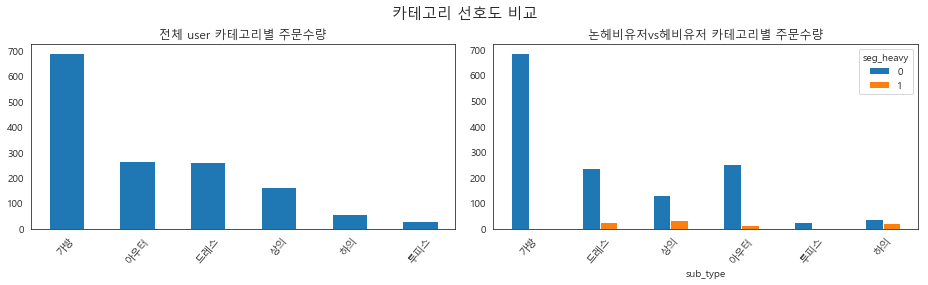

In [944]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
fig.suptitle('카테고리 선호도 비교', fontsize=15)
df.sub_type.value_counts().plot.bar(rot=50, title='전체 user 카테고리별 주문수량', ax=axes[0])
df.pivot_table(index='sub_type', columns='seg_heavy',
               values='order_date', aggfunc='count').plot.bar(rot=50, title='논헤비유저vs헤비유저 카테고리별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

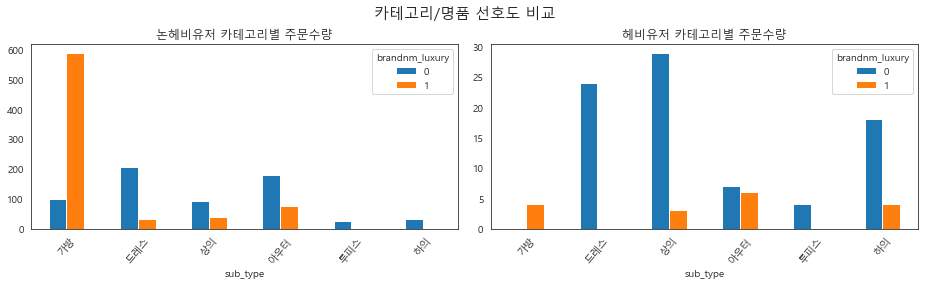

In [960]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
fig.suptitle('카테고리/명품 선호도 비교', fontsize=15)
df.query('seg_heavy==0').pivot_table(index='sub_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=50, title='논헤비유저 카테고리별 주문수량', ax=axes[0])
df.query('seg_heavy==1').pivot_table(index='sub_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=50, title='헤비유저 카테고리별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

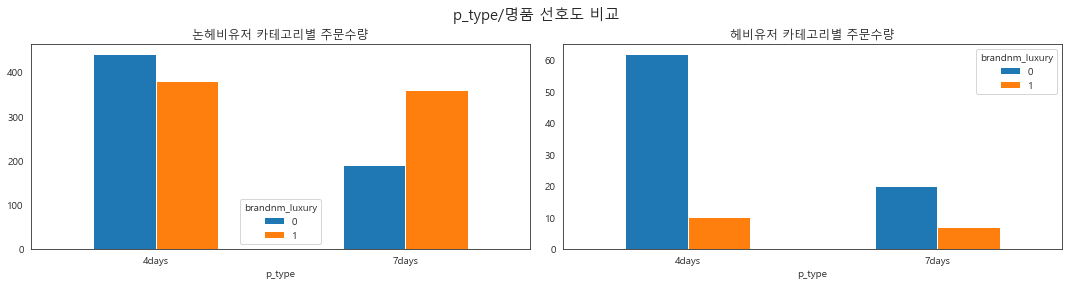

In [963]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
fig.suptitle('p_type/명품 선호도 비교', fontsize=15)
df.query('seg_heavy==0').pivot_table(index='p_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=0, title='라이트유저 카테고리별 주문수량', ax=axes[0])

df.query('seg_heavy==1').pivot_table(index='p_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=0, title='헤비유저 카테고리별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

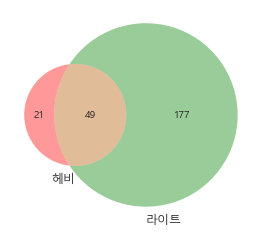

In [964]:
# 헤비 유저 vs 라이트 유저 주문 브랜드 차이 
plt.figure(figsize=(5,4))
venn2([set(df.query('seg_heavy==1')['brandnm'].tolist()),set(df.query('seg_heavy==0')['brandnm'].tolist())],
     set_labels = ('헤비','라이트'))
plt.show()

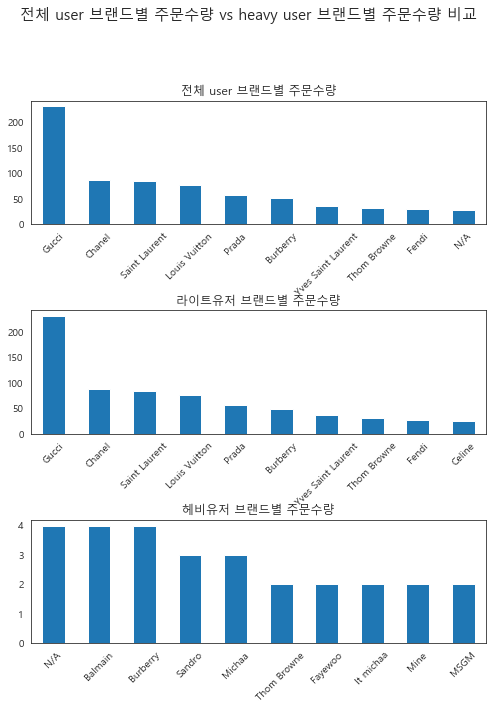

In [965]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(7,10))
fig.suptitle('전체 user 브랜드별 주문수량 vs heavy user 브랜드별 주문수량 비교', fontsize=15)
df.brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, title='전체 user 브랜드별 주문수량', ax=axes[0])
df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, title='라이트유저 브랜드별 주문수량', ax=axes[1])
df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, title='헤비유저 브랜드별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

21
Versace             2
BCBG Max Azria      2
Musinsa standard    2
S blanc             1
Covernat            1
Chi Chi London      1
Alice & Olivia      1
La maille sezane    1
Massimo Dutti       1
Bourie              1
Name: brandnm, dtype: int64


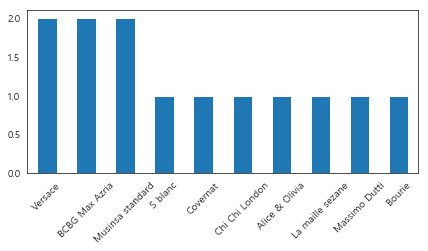

In [966]:
heavy_brand_list = list(set(df.query('seg_heavy==1')['brandnm'].tolist())-set(df.query('seg_heavy==0')['brandnm'].tolist()))
print(len(heavy_brand_list))
print(df[df.brandnm.isin(heavy_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10))
df[df.brandnm.isin(heavy_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, figsize=(7,3))

📍 insights

**Heavy user 구분 기준 주문 수량 2건 이상**

0. `전체유저`
    - 가방 >>>> 아우터 > 드레스 > 상의 >> 하의 > 투피스
    - 주문수량 상위 10위 대부분 명품브랜드
    
1. `헤비유저`그룹
    - 드레스 > 아우터 > 상의 > 가방 > 하의 >>> 투피스
    - 가방 집중도 낮으나, 대여하는 경우 대부분 명품
    - 드레스 집중도 높으며, 드레스의 경우 명품 아닌 브랜드 집중 
    - 4일권 집중
    - Gucci 집중현상 적음 :: 가방 외 카테고리 주문수량 많아서
    - 논헤비유저 그룹의 브랜드에 없는 브랜드 조회 : 명품 아님 & 건 수 낮음
    
2. `논헤비유저` 그룹
    - 가방 >>>> 아우터 > 드레스 > 상의 >> 하의 > 투피스
    - 논헤비유저의 가방 집중도 높음 & 논헤비유저 수 많음 > 전체 유저 가방 집중도 높음
    - 가방 : 명품 주문수량 높음
    - 명품인 경우 7일권도 선호하는 편

_idea?_
> - ex 논헤비유저의 명품 가방 선호 & 명품인경우 7일권 주문수량 많음 :: 명품 가방 주문시 7일권 할인이벤트 진행
> - ex 

###### seg_heavy X seg_lag

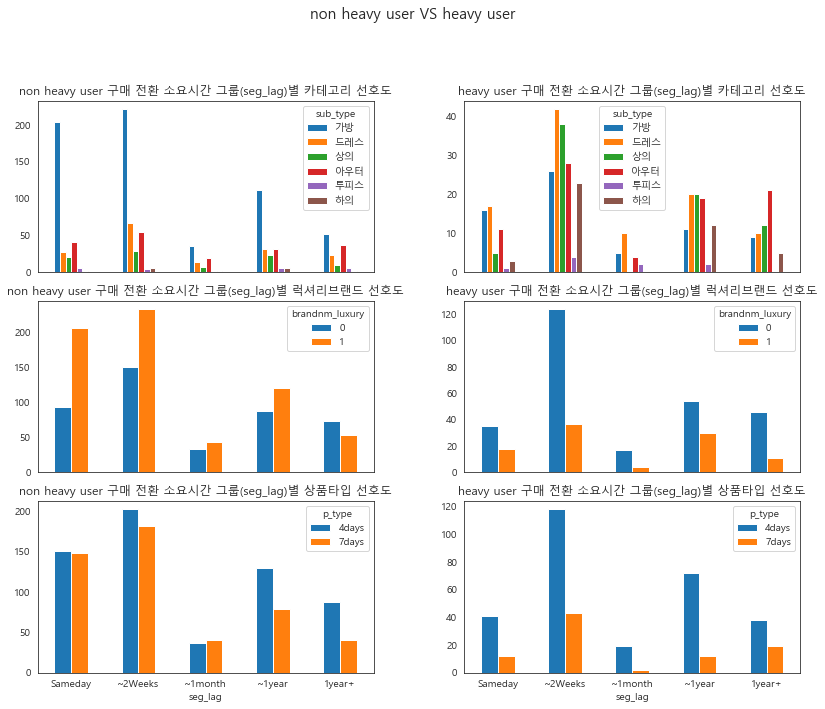

In [859]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), sharex=True)
fig.suptitle('non heavy user VS heavy user', fontsize=15)
df.query('seg_heavy==0').pivot_table(index='seg_lag',
                    columns='sub_type',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[0,0],
                                         title='non heavy user 구매 전환 소요시간 그룹(seg_lag)별 카테고리 선호도')
df.query('seg_heavy==1').pivot_table(index='seg_lag',
                                     columns='sub_type',
                                     values='user',
                                     aggfunc='count').plot(kind='bar', rot=0, ax=axes[0,1],
                                         title='heavy user 구매 전환 소요시간 그룹(seg_lag)별 카테고리 선호도')
df.query('seg_heavy==0').pivot_table(index='seg_lag',
                    columns='brandnm_luxury',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[1,0],
                                         title='non heavy user 구매 전환 소요시간 그룹(seg_lag)별 럭셔리브랜드 선호도')
df.query('seg_heavy==1').pivot_table(index='seg_lag',
                    columns='brandnm_luxury',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[1,1],
                                         title='heavy user 구매 전환 소요시간 그룹(seg_lag)별 럭셔리브랜드 선호도')
df.query('seg_heavy==0').pivot_table(index='seg_lag',
                    columns='p_type',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[2,0],
                                         title='non heavy user 구매 전환 소요시간 그룹(seg_lag)별 상품타입 선호도')
df.query('seg_heavy==1').pivot_table(index='seg_lag',
                    columns='p_type',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[2,1],
                                         title='heavy user 구매 전환 소요시간 그룹(seg_lag)별 상품타입 선호도')
fig.tight_layout()
fig.subplots_adjust(top=0.85)

📍 Insights

**논헤비유저**
1. 논헤비유저(1건구매) & lag 짧은 유저 가방 선호 현상 뚜렷
2. 논헤비유저(1건구매) & lag 짧은 유저 명품 브랜드 선호 현상 뚜렷
3. 논헤비유저(1건구매) & lag 짧은 유저  4-7권 차이 크지 않음 
    - 7일권 판매 유도해야하지 않을까?
4. 논헤비유저(1건구매) & lag 긴 유저  4일권 선호
    
**헤비유저**
1. 헤비유저(2건이상구매) & lag 짧은 유저 가방보다 의류 선호 현상 뚜렷
2. 헤비유저(2건이상구매) & lag 짧은 유저에서 특히 명품 아닌 브랜드 선호 (1번 때문)
3. 헤비유저(2건이상구매) 4일권 선호 집중

##### seg_luxury

### Trash

In [739]:
px.bar(df_user.groupby('order_month').sum(), y='order_count', title='monthly 주문 수량', width=700, height=400)

In [740]:
px.bar(df_user.groupby('order_week').sum(), y='order_count', title='weekly 주문 수량', width=700, height=400)

In [741]:
px.bar(navertrend.groupby('week').sum().reset_index(), x='week', y='index', title='네이버트렌드 클로젯 셰어 검색', width=700, height=400)

In [742]:
px.bar(df_user.groupby('order_date').sum(),y='order_count',title='Daily 주문 수량',width=700, height=400)

In [743]:
px.bar(df_user.groupby('order_dayofweek').sum(), y='order_count',title='요일별 주문 수량', width=500, height=400)

#### 📍 insights
- Monthly : 1>2>3월로 갈수록 주문 상승세

- Weekly 
    1. `order_week` 6 급하락 (2021-02-08~2021-02-14 : 10-12 설연휴, 13-14 주말) 
    2. `order_week` 12 네이버트렌드도 급상승
    
- By dayofweek 
    1. 주말에 급하락
    2. 화수목마다 급상승하는 분포의 반복
    
    ➡ 금토일에 상품을 입기 위해서일 것


#### 인기 브랜드 분석

1. 집단 구분
    - 신규 유저 vs 기존 유저
    - 헤비 유저 vs non 헤비 유저
    

2. 상기 집단 구분에서 top 15 (주문수량기준) 내 브랜드 추출 후 중복되는 브랜드 : popular_brand_list 집중 분석
    - 명품 브랜드

In [876]:
s1 = set(df.query('seg_new==1').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s2 = set(df.query('seg_new==0').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s3 = set(df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s4 = set(df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
popular_brand_list = list(s1&s2&s3&s4)
len(list(s1&s2&s3&s4))

10

In [879]:
#popular_brand_list.remove('N/A')
popular_brand_list

['Prada',
 'Thom Browne',
 'Fendi',
 'Burberry',
 'Chanel',
 'Saint Laurent',
 'Louis Vuitton',
 'Sandro',
 'Gucci']

#### 연관분석
✏️ 가설 설정 : 동일한 주에 많이 대여되는 브랜드 세트가 있지 않을까?
- http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
- https://wotres.tistory.com/entry/Association-Rule-%EC%97%B0%EA%B4%80%EC%84%B1-%EB%B6%84%EC%84%9D-in-python
- 지지도 x, y가 함께 발생할 확률 
- 향상도 1 : 품목간 관계 없음, >1 긍정 관계, <1 부정관계
- 신뢰도 : 조건부 확률 x > y

In [812]:
#! pip install mlxtend
# 인코딩용
from mlxtend.preprocessing import TransactionEncoder
# 연관분석 
from mlxtend.frequent_patterns import apriori
te=TransactionEncoder() # 객체 생성

In [880]:
# 연관규칙 리스트 생성
def toList(x):
    return list(set(x))
# 같은 주에 구매된 브랜드 리스트 & 2개 이상 필터링
df_asso=df.groupby('order_week').brandnm.apply(lambda x : toList(x)).reset_index()
df_asso['len'] = df_asso.brandnm.apply(lambda x: len(x)>=2)
df_asso.head(5)

,order_week,brandnm,len
0,1,"[MSGM, Burberry, Michaa, Chanel, It michaa, Comme des Garcons, Biker Starlet, Thom Browne, Maje, Vivienne Westwood Red Label, Chloe, Chi Chi London, Christian Dior, Andersen-Andersen, Max Mara, Saint Laurent, Nain, Imvely, Prada, Hugo Boss, Dolce & Gabbana, Jill By Jill Stuart, A.P.C., Diane von Furstenberg, Self-portrait, Gucci, Molliolli, Reneevon, Sonia Rykiel, Salvatore Ferragamo, Love Moschino, Vivienne Westwood, Givenchy, SJSJ, Celine, Bottega Veneta, Amsale, Louis Vuitton, Sandro]",True
1,2,"[Burberry, Plastic Island, The Tint, Tory Burch, Chanel, Maison Kitsune, Inusway, El estilo de Claire, Yves Saint Laurent, Thom Browne, Balmain, Chloe, Burberry London, Max Mara, Saint Laurent, The Izzat, N/A, Prada, & Other Stories, Margarin fingers, Gucci, Molliolli, Reneevon, Dior, Zooc, Danha, Sorry Too Much Love, Fendi, Vivienne Westwood, Celine, Time, Bottega Veneta, Ted Baker, Louis Vuitton, Miu Miu, Sandro, Mojosphine]",True
2,3,"[Calvin Klein, Musinsa standard, Lafudge Store, System homme, Burberry, Polo Ralph Lauren, DKNY, DELLEST, Jacquemus, JDC Lucky Chouette, Tory Burch, Jigott, Michaa, Chanel, More Or Less, Versace, Maison Kitsune, Nakes, Not Your Rose, Isabel Marant, Comme des Garcons, El estilo de Claire, Yves Saint Laurent, Thom Browne, Vivienne Westwood Red Label, Chloe, Massimo Dutti, Burberry London, Marni, Christian Dior, Max Mara, Greedilous, Saint Laurent, Lanvin, N/A, Imvely, Prada, Wonder Style, Delvaux, Dolce & Gabbana, Jill By Jill Stuart, Fayewoo, The Clozet, Adidas X Stella Mccartney, Maison Margiela, khrisjoy, Gucci, Molliolli, Vw vera Wang, Covernat, Dior, Mulberry, Fendi, Cos, Sacai, Salvatore Ferragamo, Vivienne Westwood, Celine, Balenciaga, ACNE STUDIOS, H&Moschino, Ted Baker, Bottega Veneta, Louis Vuitton, Miu Miu, Mojosphine]",True
3,4,"[Lmml Studio, Burberry, Polo Ralph Lauren, Plastic Island, Diagonal, Jigott, Chanel, It michaa, Not Your Rose, El estilo de Claire, Yves Saint Laurent, Thom Browne, Maje, Moschino, Chloe, Jill Stuart, Allsaints, S blanc, Christian Dior, Ami, Saint Laurent, N/A, Imvely, Prada, BCBG Max Azria, Allen.O, Dolce & Gabbana, Fayewoo, The Clozet, Diane von Furstenberg, Egoist, On&On, Gucci, Michael Michael Kors, Molliolli, Johnny Hates Jazz, Theory, Fendi, Sonia Rykiel, Salvatore Ferragamo, Celine, Balenciaga, Spring Crocus, Eight Slate, ACNE STUDIOS, Bottega Veneta, Lucky Chouette, Escada, Louis Vuitton, Sandro, Mojosphine]",True
4,5,"[EunjoKoh, Burberry, Alexander Mcqueen, DKNY, Ralph Lauren, Valentino, Michaa, Chanel, Time homme, Overdueflair, It michaa, Saint James, Isabel Marant, El estilo de Claire, Yves Saint Laurent, Thom Browne, Balmain, Maje, Chloe, Marni, Banana Republic, Christian Dior, Max Mara, Saint Laurent, N/A, Imvely, Prada, Marc New York, thom browne, Dolce & Gabbana, Dewl, The Clozet, Rouje, Self-portrait, Gucci, Molliolli, Off White, Aspesi, Dior, Fendi, BYREDO, Sorry Too Much Love, Vivienne Westwood, Stylenanda, Givenchy, SJSJ, Bulgari, Olive des Olive, Ted Baker, Louis Vuitton, Miu Miu, VOV, Sandro, Carven]",True


In [881]:
asso_list = list(df_asso.brandnm)

In [882]:
asso_list[:1]

[['MSGM',
  'Burberry',
  'Michaa',
  'Chanel',
  'It michaa',
  'Comme des Garcons',
  'Biker Starlet',
  'Thom Browne',
  'Maje',
  'Vivienne Westwood Red Label',
  'Chloe',
  'Chi Chi London',
  'Christian Dior',
  'Andersen-Andersen',
  'Max Mara',
  'Saint Laurent',
  'Nain',
  'Imvely',
  'Prada',
  'Hugo Boss',
  'Dolce & Gabbana',
  'Jill By Jill Stuart',
  'A.P.C.',
  'Diane von Furstenberg',
  'Self-portrait',
  'Gucci',
  'Molliolli',
  'Reneevon',
  'Sonia Rykiel',
  'Salvatore Ferragamo',
  'Love Moschino',
  'Vivienne Westwood',
  'Givenchy',
  'SJSJ',
  'Celine',
  'Bottega Veneta',
  'Amsale',
  'Louis Vuitton',
  'Sandro']]

In [883]:
asso_list_encoded = te.fit(asso_list).transform(asso_list)
# one hot encoding
asso_list_encoded=asso_list_encoded.astype("int")
df_asso_encoded = pd.DataFrame(asso_list_encoded, columns=te.columns_)

In [814]:
df_asso_encoded.columns

Index(['& Other Stories', 'A BY A', 'A.P.C.', 'ACNE STUDIOS', 'Adidas',
       'Adidas X Stella Mccartney', 'Akro', 'Alexander Mcqueen',
       'Alexander Wang', 'Alice & Olivia',
       ...
       'Wai Kei', 'Wonder Style', 'Your Name Here', 'Yves Saint Laurent',
       'Zadig & Voltaire', 'Zooc', 'cecilie bahnsen', 'khrisjoy', 'roajeu',
       'thom browne'],
      dtype='object', length=247)

In [815]:
df_asso_encoded.head(5)

,& Other Stories,A BY A,A.P.C.,ACNE STUDIOS,Adidas,Adidas X Stella Mccartney,Akro,Alexander Mcqueen,Alexander Wang,Alice & Olivia,...,Wai Kei,Wonder Style,Your Name Here,Yves Saint Laurent,Zadig & Voltaire,Zooc,cecilie bahnsen,khrisjoy,roajeu,thom browne
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [884]:
apriori(df_asso_encoded, min_support=0.7, use_colnames=True)

,support,itemsets
0,0.50,(Balmain)
1,0.57,(Bottega Veneta)
2,0.86,(Burberry)
3,0.50,(Burberry London)
4,0.93,(Celine)
...,...,...
120766,0.50,"(Prada, Yves Saint Laurent, Thom Browne, Maje, Fendi, Chloe, Burberry, Dolce & Gabbana, Celine, Chanel, Saint Laurent, Louis Vuitton, Sandro, Gucci)"
120767,0.50,"(Prada, Yves Saint Laurent, Thom Browne, Maje, Fendi, Chloe, Burberry, Dolce & Gabbana, Christian Dior, Chanel, Saint Laurent, Louis Vuitton, Sandro, Gucci)"
120768,0.50,"(Prada, Yves Saint Laurent, Thom Browne, Maje, Fendi, Chloe, Burberry, Dolce & Gabbana, Chanel, Saint Laurent, Louis Vuitton, Sandro, El estilo de Claire, Gucci)"
120769,0.50,"(Prada, Yves Saint Laurent, Thom Browne, Maje, Fendi, Chloe, Burberry, Dolce & Gabbana, Max Mara, Chanel, Saint Laurent, Louis Vuitton, Sandro, Gucci)"


In [889]:
df_frequent_itemsets= apriori(df_asso_encoded, min_support=0.7, use_colnames=True)
df_frequent_itemsets['len']=df_frequent_itemsets['itemsets'].apply(lambda x : len(x))
df_frequent_itemsets[df_frequent_itemsets['len']>=2]

,support,itemsets,len
17,0.79,"(Burberry, Celine)",2
18,0.86,"(Burberry, Chanel)",2
19,0.79,"(Chloe, Burberry)",2
20,0.71,"(Christian Dior, Burberry)",2
21,0.71,"(Burberry, Dolce & Gabbana)",2
...,...,...,...
5246,0.71,"(Prada, Yves Saint Laurent, Thom Browne, Fendi, Burberry, Celine, Chanel, Saint Laurent, Louis Vuitton, Gucci)",10
5247,0.71,"(Prada, Yves Saint Laurent, Thom Browne, Fendi, Chloe, Burberry, Chanel, Saint Laurent, Louis Vuitton, Gucci)",10
5248,0.71,"(Prada, Yves Saint Laurent, Thom Browne, Fendi, Burberry, Max Mara, Chanel, Saint Laurent, Louis Vuitton, Gucci)",10
5249,0.71,"(Prada, Yves Saint Laurent, Thom Browne, Fendi, Burberry, Chanel, Saint Laurent, Louis Vuitton, N/A, Gucci)",10


**- 가방과 아우터 카테고리 간 지지도, 신뢰도, 향상도 높은 편이나, 전체 주문 수량의 50% 정도이기 때문인 것 같음**

In [892]:
association_rules(df_frequent_itemsets, metric='support', min_threshold=0.9)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Chanel),(Celine),1.00,0.93,0.93,0.93,1.00,0.00,1.00
1,(Celine),(Chanel),0.93,1.00,0.93,1.00,1.00,0.00,inf
2,(Celine),(Gucci),0.93,1.00,0.93,1.00,1.00,0.00,inf
3,(Gucci),(Celine),1.00,0.93,0.93,0.93,1.00,0.00,1.00
4,(Chanel),(Gucci),1.00,1.00,1.00,1.00,1.00,0.00,inf
...,...,...,...,...,...,...,...,...,...
607,(Thom Browne),"(Prada, Chanel, Saint Laurent, Louis Vuitton, Gucci)",0.93,0.93,0.93,1.00,1.08,0.07,inf
608,(Chanel),"(Prada, Thom Browne, Saint Laurent, Louis Vuitton, Gucci)",1.00,0.93,0.93,0.93,1.00,0.00,1.00
609,(Saint Laurent),"(Prada, Thom Browne, Chanel, Louis Vuitton, Gucci)",0.93,0.93,0.93,1.00,1.08,0.07,inf
610,(Louis Vuitton),"(Prada, Thom Browne, Chanel, Saint Laurent, Gucci)",0.93,0.93,0.93,1.00,1.08,0.07,inf


##### 📍 insights
연관분석 결과 브랜드가 동일한 주에 구매될 확률 (0.9이상) 높은 itemsets

⚡ 비즈니스 관련 인사이트 생각해보기